# Classifier using LSTM layers

## 1. Importing Libraries

In [1]:
import torch

import numpy as np

data_folder = '../data/ctrpts'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [2]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/ctrlpts/calculator_ctrlpt.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/ctrlpts/camera_ctrlpt.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/ctrlpts/cell_phone_ctrlpt.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [3]:
calculator_data.get('train').shape, camera_data.get('train').shape, cellphone_data.get('train').shape

((17928,), (17938,), (17976,))

In [4]:
from sklearn.model_selection import train_test_split

# Limiting data to 5000 points per class
def slice_data(data):
    # Assuming that the data arrays in each 'train', 'test', 'valid' are already shuffled
    sliced = []
    for key in ['train', 'test', 'valid']:
        # Slicing each segment
        sliced.append(data[key])
    # Concatenate slices from train, test, valid
    return np.concatenate(sliced)

# Slicing the data
calculator_sliced = slice_data(calculator_data)[:5000]
camera_sliced = slice_data(camera_data)[:5000]
cellphone_sliced = slice_data(cellphone_data)[:5000]

# Concatenate all sliced data
def concatenate_data(*datasets):
    features = []
    labels = []
    for data, cid in zip(datasets, class_id.values()):
        features.append(data)
        labels.extend([cid] * len(data))
    features = np.concatenate(features)
    labels = np.array(labels)
    return features, labels

features, labels = concatenate_data(calculator_sliced, camera_sliced, cellphone_sliced)

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12000,), (12000,), (3000,), (3000,))

In [6]:
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from scipy.interpolate import interp1d

def standardize_lengths(data, target_length=29):
    standardized_data = []

    for sequence in data:
        # Current length of the sequence
        current_length = sequence.shape[0]
        
        # Create an array of indices based on current length
        current_indices = np.linspace(0, 1, current_length)
        
        # Target indices for interpolation
        target_indices = np.linspace(0, 1, target_length)
        
        # Initialize interpolated sequence
        interpolated_sequence = np.zeros((target_length, sequence.shape[1]))
        
        # Interpolate each channel
        for i in range(sequence.shape[1]):
            # Interpolate the i-th channel
            interpolator = interp1d(current_indices, sequence[:, i], kind='linear')
            interpolated_sequence[:, i] = interpolator(target_indices)
        
        # Append the interpolated sequence to the standardized data list
        standardized_data.append(interpolated_sequence)

    return np.array(standardized_data)

# Apply standardization on X_train and X_test
X_train_standardized = standardize_lengths(X_train)
X_test_standardized = standardize_lengths(X_test)

def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train_standardized, X_test_standardized, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
print(len(train_loader))
print(len(test_loader))

188
47


In [8]:
X_train_standardized.shape, X_test_standardized.shape

((12000, 29, 3), (3000, 29, 3))

## 3. Model Building

### 3.1. Quantum Layer

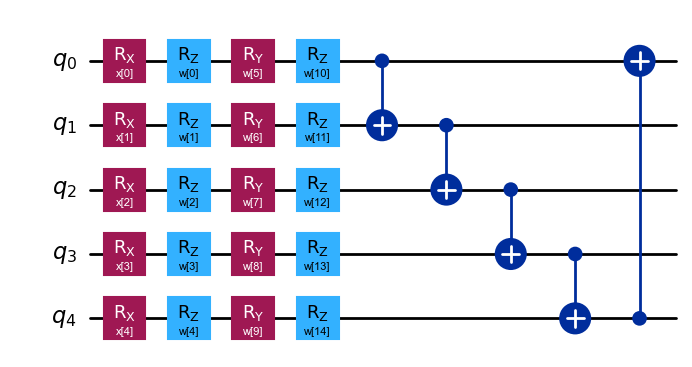

In [9]:
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)

    for i in range(n):
        circuit.rx(features[i], i)

    return circuit

def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)

    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)

    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)

    for i in range(n):
        circuit.rz(weights[2*n+i], i)

    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)

    return circuit

# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [10]:
from qiskit_machine_learning.connectors import TorchConnector
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        #self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        #self.bn1 = nn.BatchNorm1d(num_features=16)
        #self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        #self.bn2 = nn.BatchNorm1d(num_features=32)
        #self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        #self.bn3 = nn.BatchNorm1d(num_features=64)
        #self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        #self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        #self.bn4 = nn.BatchNorm1d(num_features=128)
        #self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=29, hidden_size=29, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(14, 14)
        self.fc2 = nn.Linear(14, 14)

        # Quantum layer
        # self.fc3 = nn.Linear(14, n_qubits)
        # self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(14, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        #x = x.permute(0, 2, 1)

        # Convolutional layers
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = self.pool1(x)
        
        #x = F.relu(self.bn2(self.conv2(x)))
        #x = self.pool2(x)
        
        #x = F.relu(self.bn3(self.conv3(x)))
        #x = self.pool3(x)
        
        #x = F.relu(self.bn4(self.conv4(x)))
        #x = self.pool4(x)

        # Reshape for LSTM
        #x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        # x = F.relu(self.fc3(x))
        # x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [11]:
checkpoint_filepath = 'models/2edition_lstm/best_model_weights_3classes_ctrlpts.pth'

In [12]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 188/188 [00:01<00:00, 174.81it/s]


Epoch 1, Accuracy: 0.5750833333333333, Loss: 0.9727273814855738, Validation Accuracy: 0.638, Validation Loss: 0.8168821930885315


100%|██████████| 188/188 [00:01<00:00, 170.06it/s]


Epoch 2, Accuracy: 0.6358333333333334, Loss: 0.7372376844286919, Validation Accuracy: 0.6433333333333333, Validation Loss: 0.6719253063201904


100%|██████████| 188/188 [00:01<00:00, 167.32it/s]


Epoch 3, Accuracy: 0.6389166666666667, Loss: 0.6526984201466783, Validation Accuracy: 0.6416666666666667, Validation Loss: 0.6317031383514404


100%|██████████| 188/188 [00:01<00:00, 174.25it/s]


Epoch 4, Accuracy: 0.6433333333333333, Loss: 0.6180904499710874, Validation Accuracy: 0.6403333333333333, Validation Loss: 0.7095404863357544


100%|██████████| 188/188 [00:01<00:00, 167.78it/s]


Epoch 5, Accuracy: 0.6451666666666667, Loss: 0.601261001318059, Validation Accuracy: 0.6466666666666666, Validation Loss: 0.6282162070274353


100%|██████████| 188/188 [00:01<00:00, 168.81it/s]


Epoch 6, Accuracy: 0.6458333333333334, Loss: 0.5837194959216929, Validation Accuracy: 0.641, Validation Loss: 0.5978966951370239


100%|██████████| 188/188 [00:01<00:00, 166.05it/s]


Epoch 7, Accuracy: 0.6471666666666667, Loss: 0.5699590122763146, Validation Accuracy: 0.6363333333333333, Validation Loss: 0.5944989919662476


100%|██████████| 188/188 [00:01<00:00, 172.47it/s]


Epoch 8, Accuracy: 0.6489166666666667, Loss: 0.5637497768757191, Validation Accuracy: 0.6496666666666666, Validation Loss: 0.5964765548706055


100%|██████████| 188/188 [00:01<00:00, 157.31it/s]


Epoch 9, Accuracy: 0.6491666666666667, Loss: 0.5532540728120093, Validation Accuracy: 0.6426666666666667, Validation Loss: 0.5747808218002319


100%|██████████| 188/188 [00:01<00:00, 162.64it/s]


Epoch 10, Accuracy: 0.6505833333333333, Loss: 0.5433387930722947, Validation Accuracy: 0.6463333333333333, Validation Loss: 0.5752612352371216


100%|██████████| 188/188 [00:01<00:00, 157.96it/s]


Epoch 11, Accuracy: 0.6508333333333334, Loss: 0.5369904737206216, Validation Accuracy: 0.6453333333333333, Validation Loss: 0.5737741589546204


100%|██████████| 188/188 [00:01<00:00, 164.71it/s]


Epoch 12, Accuracy: 0.6509166666666667, Loss: 0.5280615728586278, Validation Accuracy: 0.6443333333333333, Validation Loss: 0.5569844245910645


100%|██████████| 188/188 [00:01<00:00, 156.26it/s]


Epoch 13, Accuracy: 0.65125, Loss: 0.5280145505007278, Validation Accuracy: 0.6466666666666666, Validation Loss: 0.5603083372116089


100%|██████████| 188/188 [00:01<00:00, 172.80it/s]


Epoch 14, Accuracy: 0.6504166666666666, Loss: 0.5158177663354163, Validation Accuracy: 0.647, Validation Loss: 0.5625824332237244


100%|██████████| 188/188 [00:01<00:00, 162.25it/s]


Epoch 15, Accuracy: 0.6505833333333333, Loss: 0.5158371882552796, Validation Accuracy: 0.648, Validation Loss: 0.5604867339134216


100%|██████████| 188/188 [00:01<00:00, 165.83it/s]


Epoch 16, Accuracy: 0.6501666666666667, Loss: 0.5137546832891221, Validation Accuracy: 0.6466666666666666, Validation Loss: 0.5611690878868103


100%|██████████| 188/188 [00:01<00:00, 170.90it/s]


Epoch 17, Accuracy: 0.6501666666666667, Loss: 0.5052630457472294, Validation Accuracy: 0.6506666666666666, Validation Loss: 0.5563392043113708


100%|██████████| 188/188 [00:01<00:00, 156.80it/s]


Epoch 18, Accuracy: 0.6524166666666666, Loss: 0.49952591400831303, Validation Accuracy: 0.6436666666666667, Validation Loss: 0.5550009608268738


100%|██████████| 188/188 [00:01<00:00, 175.41it/s]


Epoch 19, Accuracy: 0.65175, Loss: 0.49437800517424624, Validation Accuracy: 0.6503333333333333, Validation Loss: 0.5527360439300537


100%|██████████| 188/188 [00:01<00:00, 163.07it/s]


Epoch 20, Accuracy: 0.6525, Loss: 0.48687027363066976, Validation Accuracy: 0.6466666666666666, Validation Loss: 0.5574779510498047


100%|██████████| 188/188 [00:01<00:00, 176.16it/s]


Epoch 21, Accuracy: 0.6525, Loss: 0.4826160358621719, Validation Accuracy: 0.6476666666666666, Validation Loss: 0.5604032874107361


100%|██████████| 188/188 [00:01<00:00, 159.73it/s]


Epoch 22, Accuracy: 0.6520833333333333, Loss: 0.4835592265775863, Validation Accuracy: 0.6376666666666667, Validation Loss: 0.5478215217590332


100%|██████████| 188/188 [00:01<00:00, 172.44it/s]


Epoch 23, Accuracy: 0.65375, Loss: 0.4768440861334192, Validation Accuracy: 0.652, Validation Loss: 0.5532984137535095


100%|██████████| 188/188 [00:01<00:00, 173.31it/s]


Epoch 24, Accuracy: 0.6545, Loss: 0.4730693904009271, Validation Accuracy: 0.6426666666666667, Validation Loss: 0.5454654097557068


100%|██████████| 188/188 [00:01<00:00, 164.99it/s]


Epoch 25, Accuracy: 0.6545, Loss: 0.46610042643039784, Validation Accuracy: 0.647, Validation Loss: 0.5504948496818542


100%|██████████| 188/188 [00:01<00:00, 168.63it/s]


Epoch 26, Accuracy: 0.6538333333333334, Loss: 0.46720632038852, Validation Accuracy: 0.645, Validation Loss: 0.5548422932624817


100%|██████████| 188/188 [00:01<00:00, 153.16it/s]


Epoch 27, Accuracy: 0.6555, Loss: 0.46509601064818973, Validation Accuracy: 0.6483333333333333, Validation Loss: 0.5460221171379089


100%|██████████| 188/188 [00:01<00:00, 155.55it/s]


Epoch 28, Accuracy: 0.6554166666666666, Loss: 0.46572311507894637, Validation Accuracy: 0.64, Validation Loss: 0.5594845414161682


100%|██████████| 188/188 [00:01<00:00, 173.98it/s]


Epoch 29, Accuracy: 0.656, Loss: 0.45864295848506564, Validation Accuracy: 0.645, Validation Loss: 0.5359248518943787


100%|██████████| 188/188 [00:01<00:00, 166.38it/s]


Epoch 30, Accuracy: 0.6559166666666667, Loss: 0.45200827210507494, Validation Accuracy: 0.64, Validation Loss: 0.5674900412559509


100%|██████████| 188/188 [00:01<00:00, 168.19it/s]


Epoch 31, Accuracy: 0.6563333333333333, Loss: 0.4490195045128782, Validation Accuracy: 0.6476666666666666, Validation Loss: 0.5549936294555664


100%|██████████| 188/188 [00:01<00:00, 167.61it/s]


Epoch 32, Accuracy: 0.6559166666666667, Loss: 0.4491247645717986, Validation Accuracy: 0.6473333333333333, Validation Loss: 0.5439598560333252


100%|██████████| 188/188 [00:01<00:00, 162.12it/s]


Epoch 33, Accuracy: 0.657, Loss: 0.44498591822512606, Validation Accuracy: 0.653, Validation Loss: 0.5702449083328247


100%|██████████| 188/188 [00:01<00:00, 175.20it/s]


Epoch 34, Accuracy: 0.656, Loss: 0.44409235202251596, Validation Accuracy: 0.6496666666666666, Validation Loss: 0.5577813982963562


100%|██████████| 188/188 [00:01<00:00, 168.12it/s]


Epoch 35, Accuracy: 0.6564166666666666, Loss: 0.4461836003242655, Validation Accuracy: 0.6496666666666666, Validation Loss: 0.5504945516586304


100%|██████████| 188/188 [00:01<00:00, 156.61it/s]


Epoch 36, Accuracy: 0.6565833333333333, Loss: 0.44186328034451666, Validation Accuracy: 0.6466666666666666, Validation Loss: 0.5574239492416382


100%|██████████| 188/188 [00:01<00:00, 174.33it/s]


Epoch 37, Accuracy: 0.6576666666666666, Loss: 0.43746501730477555, Validation Accuracy: 0.6516666666666666, Validation Loss: 0.5811984539031982


100%|██████████| 188/188 [00:01<00:00, 180.09it/s]


Epoch 38, Accuracy: 0.65825, Loss: 0.4340666925653498, Validation Accuracy: 0.647, Validation Loss: 0.5661680102348328


100%|██████████| 188/188 [00:01<00:00, 182.59it/s]


Epoch 39, Accuracy: 0.6579166666666667, Loss: 0.4309394031446031, Validation Accuracy: 0.65, Validation Loss: 0.5545380115509033


100%|██████████| 188/188 [00:01<00:00, 172.17it/s]


Epoch 40, Accuracy: 0.6586666666666666, Loss: 0.4288271562533176, Validation Accuracy: 0.645, Validation Loss: 0.5648906826972961


100%|██████████| 188/188 [00:01<00:00, 181.07it/s]


Epoch 41, Accuracy: 0.6585, Loss: 0.4291154385564175, Validation Accuracy: 0.6406666666666667, Validation Loss: 0.5897572040557861


100%|██████████| 188/188 [00:01<00:00, 163.17it/s]


Epoch 42, Accuracy: 0.6565833333333333, Loss: 0.43382287833918914, Validation Accuracy: 0.6523333333333333, Validation Loss: 0.5821940898895264


100%|██████████| 188/188 [00:01<00:00, 155.92it/s]


Epoch 43, Accuracy: 0.6584166666666667, Loss: 0.42704019838191093, Validation Accuracy: 0.648, Validation Loss: 0.5937959551811218


100%|██████████| 188/188 [00:01<00:00, 167.97it/s]


Epoch 44, Accuracy: 0.6596666666666666, Loss: 0.4176095575094223, Validation Accuracy: 0.651, Validation Loss: 0.5832245945930481


100%|██████████| 188/188 [00:01<00:00, 148.84it/s]


Epoch 45, Accuracy: 0.6576666666666666, Loss: 0.4260168822204813, Validation Accuracy: 0.6456666666666667, Validation Loss: 0.5818333625793457


100%|██████████| 188/188 [00:01<00:00, 138.57it/s]


Epoch 46, Accuracy: 0.65825, Loss: 0.42288059289468094, Validation Accuracy: 0.6486666666666666, Validation Loss: 0.5677983164787292


100%|██████████| 188/188 [00:01<00:00, 146.18it/s]


Epoch 47, Accuracy: 0.6591666666666667, Loss: 0.4140126465799961, Validation Accuracy: 0.6503333333333333, Validation Loss: 0.5754350423812866


100%|██████████| 188/188 [00:01<00:00, 152.64it/s]


Epoch 48, Accuracy: 0.6593333333333333, Loss: 0.41364051322353645, Validation Accuracy: 0.648, Validation Loss: 0.596824586391449


100%|██████████| 188/188 [00:01<00:00, 146.59it/s]


Epoch 49, Accuracy: 0.6595, Loss: 0.41432210311610645, Validation Accuracy: 0.644, Validation Loss: 0.6022321581840515


100%|██████████| 188/188 [00:01<00:00, 160.50it/s]


Epoch 50, Accuracy: 0.6598333333333334, Loss: 0.42266689764058335, Validation Accuracy: 0.6476666666666666, Validation Loss: 0.5831364393234253


100%|██████████| 188/188 [00:01<00:00, 175.05it/s]


Epoch 51, Accuracy: 0.6593333333333333, Loss: 0.422036266469575, Validation Accuracy: 0.6503333333333333, Validation Loss: 0.6343135237693787


100%|██████████| 188/188 [00:01<00:00, 179.97it/s]


Epoch 52, Accuracy: 0.6599166666666667, Loss: 0.4139554984074958, Validation Accuracy: 0.645, Validation Loss: 0.6282438635826111


100%|██████████| 188/188 [00:01<00:00, 172.79it/s]


Epoch 53, Accuracy: 0.6601666666666667, Loss: 0.40801673984908043, Validation Accuracy: 0.652, Validation Loss: 0.6269167065620422


100%|██████████| 188/188 [00:01<00:00, 165.52it/s]


Epoch 54, Accuracy: 0.659, Loss: 0.412158275459041, Validation Accuracy: 0.649, Validation Loss: 0.5907004475593567


100%|██████████| 188/188 [00:01<00:00, 141.42it/s]


Epoch 55, Accuracy: 0.6589166666666667, Loss: 0.41708541273119604, Validation Accuracy: 0.645, Validation Loss: 0.5978394150733948


100%|██████████| 188/188 [00:01<00:00, 142.99it/s]


Epoch 56, Accuracy: 0.6603333333333333, Loss: 0.40618532991155665, Validation Accuracy: 0.65, Validation Loss: 0.5906656384468079


100%|██████████| 188/188 [00:01<00:00, 177.71it/s]


Epoch 57, Accuracy: 0.6605, Loss: 0.4029349900306539, Validation Accuracy: 0.6496666666666666, Validation Loss: 0.61379474401474


100%|██████████| 188/188 [00:01<00:00, 173.67it/s]


Epoch 58, Accuracy: 0.6594166666666667, Loss: 0.41017091575455156, Validation Accuracy: 0.648, Validation Loss: 0.6110801100730896


100%|██████████| 188/188 [00:01<00:00, 147.21it/s]


Epoch 59, Accuracy: 0.659, Loss: 0.4186694875676581, Validation Accuracy: 0.6533333333333333, Validation Loss: 0.6118602156639099


100%|██████████| 188/188 [00:01<00:00, 146.72it/s]


Epoch 60, Accuracy: 0.6573333333333333, Loss: 0.4182547741430871, Validation Accuracy: 0.651, Validation Loss: 0.6573644876480103


100%|██████████| 188/188 [00:01<00:00, 157.59it/s]


Epoch 61, Accuracy: 0.6593333333333333, Loss: 0.4147420069004627, Validation Accuracy: 0.648, Validation Loss: 0.5964608788490295


100%|██████████| 188/188 [00:01<00:00, 153.12it/s]


Epoch 62, Accuracy: 0.6606666666666666, Loss: 0.39846724192512795, Validation Accuracy: 0.6473333333333333, Validation Loss: 0.6110795140266418


100%|██████████| 188/188 [00:01<00:00, 141.09it/s]


Epoch 63, Accuracy: 0.6603333333333333, Loss: 0.4020933106224588, Validation Accuracy: 0.6493333333333333, Validation Loss: 0.648564875125885


100%|██████████| 188/188 [00:01<00:00, 153.47it/s]


Epoch 64, Accuracy: 0.6606666666666666, Loss: 0.4004280499004303, Validation Accuracy: 0.648, Validation Loss: 0.6082329154014587


100%|██████████| 188/188 [00:01<00:00, 144.03it/s]


Epoch 65, Accuracy: 0.65875, Loss: 0.41862905247414367, Validation Accuracy: 0.6286666666666667, Validation Loss: 0.6635748744010925


100%|██████████| 188/188 [00:01<00:00, 168.41it/s]


Epoch 66, Accuracy: 0.6560833333333334, Loss: 0.41890011252240933, Validation Accuracy: 0.645, Validation Loss: 0.6707659959793091


100%|██████████| 188/188 [00:01<00:00, 147.86it/s]


Epoch 67, Accuracy: 0.658, Loss: 0.41898116184041856, Validation Accuracy: 0.6443333333333333, Validation Loss: 0.6585384011268616


100%|██████████| 188/188 [00:01<00:00, 169.86it/s]


Epoch 68, Accuracy: 0.65975, Loss: 0.40462588487153356, Validation Accuracy: 0.6493333333333333, Validation Loss: 0.6440069079399109


100%|██████████| 188/188 [00:01<00:00, 150.22it/s]


Epoch 69, Accuracy: 0.6610833333333334, Loss: 0.3966101089373548, Validation Accuracy: 0.6493333333333333, Validation Loss: 0.6763594746589661


100%|██████████| 188/188 [00:01<00:00, 144.86it/s]


Epoch 70, Accuracy: 0.6603333333333333, Loss: 0.398888424514456, Validation Accuracy: 0.651, Validation Loss: 0.6427134871482849


100%|██████████| 188/188 [00:01<00:00, 158.14it/s]


Epoch 71, Accuracy: 0.66125, Loss: 0.3924828602119963, Validation Accuracy: 0.6483333333333333, Validation Loss: 0.6481059789657593


100%|██████████| 188/188 [00:01<00:00, 133.63it/s]


Epoch 72, Accuracy: 0.6609166666666667, Loss: 0.39365406366104777, Validation Accuracy: 0.6493333333333333, Validation Loss: 0.6659274697303772


100%|██████████| 188/188 [00:01<00:00, 165.05it/s]


Epoch 73, Accuracy: 0.6614166666666667, Loss: 0.39486102831173453, Validation Accuracy: 0.6443333333333333, Validation Loss: 0.6891692280769348


100%|██████████| 188/188 [00:01<00:00, 154.59it/s]


Epoch 74, Accuracy: 0.6573333333333333, Loss: 0.4115648746807524, Validation Accuracy: 0.6493333333333333, Validation Loss: 0.638637125492096


100%|██████████| 188/188 [00:01<00:00, 149.16it/s]


Epoch 75, Accuracy: 0.6606666666666666, Loss: 0.3974143127970239, Validation Accuracy: 0.6533333333333333, Validation Loss: 0.696692705154419


100%|██████████| 188/188 [00:01<00:00, 169.82it/s]


Epoch 76, Accuracy: 0.6601666666666667, Loss: 0.4032074969182623, Validation Accuracy: 0.6496666666666666, Validation Loss: 0.596724808216095


100%|██████████| 188/188 [00:01<00:00, 156.02it/s]


Epoch 77, Accuracy: 0.6601666666666667, Loss: 0.406583382411206, Validation Accuracy: 0.6496666666666666, Validation Loss: 0.6387270092964172


100%|██████████| 188/188 [00:01<00:00, 158.16it/s]


Epoch 78, Accuracy: 0.661, Loss: 0.39612661738027916, Validation Accuracy: 0.644, Validation Loss: 0.6045114398002625


100%|██████████| 188/188 [00:01<00:00, 156.72it/s]


Epoch 79, Accuracy: 0.6600833333333334, Loss: 0.39939027604587535, Validation Accuracy: 0.651, Validation Loss: 0.6635108590126038


100%|██████████| 188/188 [00:01<00:00, 142.44it/s]


Epoch 80, Accuracy: 0.6611666666666667, Loss: 0.3996872030040051, Validation Accuracy: 0.6536666666666666, Validation Loss: 0.6302440166473389


100%|██████████| 188/188 [00:01<00:00, 168.95it/s]


Epoch 81, Accuracy: 0.6599166666666667, Loss: 0.39959295791514376, Validation Accuracy: 0.6503333333333333, Validation Loss: 0.6614793539047241


100%|██████████| 188/188 [00:01<00:00, 163.70it/s]


Epoch 82, Accuracy: 0.661, Loss: 0.3913155413688497, Validation Accuracy: 0.6486666666666666, Validation Loss: 0.6646720767021179


100%|██████████| 188/188 [00:01<00:00, 176.59it/s]


Epoch 83, Accuracy: 0.6605, Loss: 0.39493476694568674, Validation Accuracy: 0.65, Validation Loss: 0.6323022246360779


100%|██████████| 188/188 [00:01<00:00, 161.61it/s]


Epoch 84, Accuracy: 0.6605833333333333, Loss: 0.3952701132982335, Validation Accuracy: 0.65, Validation Loss: 0.615858256816864


100%|██████████| 188/188 [00:01<00:00, 173.49it/s]


Epoch 85, Accuracy: 0.66125, Loss: 0.391045111132429, Validation Accuracy: 0.644, Validation Loss: 0.6583153009414673


100%|██████████| 188/188 [00:01<00:00, 154.06it/s]


Epoch 86, Accuracy: 0.6586666666666666, Loss: 0.4065566563859899, Validation Accuracy: 0.6446666666666667, Validation Loss: 0.672298014163971


100%|██████████| 188/188 [00:01<00:00, 162.72it/s]


Epoch 87, Accuracy: 0.6594166666666667, Loss: 0.40377735584340196, Validation Accuracy: 0.65, Validation Loss: 0.6781659722328186


100%|██████████| 188/188 [00:01<00:00, 176.24it/s]


Epoch 88, Accuracy: 0.66125, Loss: 0.3908768833634701, Validation Accuracy: 0.6476666666666666, Validation Loss: 0.7021650075912476


100%|██████████| 188/188 [00:01<00:00, 155.44it/s]


Epoch 89, Accuracy: 0.6611666666666667, Loss: 0.397876547292826, Validation Accuracy: 0.648, Validation Loss: 0.6377207040786743


100%|██████████| 188/188 [00:01<00:00, 174.36it/s]


Epoch 90, Accuracy: 0.6615, Loss: 0.39406744034049357, Validation Accuracy: 0.6506666666666666, Validation Loss: 0.705805242061615


100%|██████████| 188/188 [00:01<00:00, 178.55it/s]


Epoch 91, Accuracy: 0.6616666666666666, Loss: 0.3913913648179237, Validation Accuracy: 0.6446666666666667, Validation Loss: 0.6294611096382141


100%|██████████| 188/188 [00:01<00:00, 161.59it/s]


Epoch 92, Accuracy: 0.6605, Loss: 0.3951681942698803, Validation Accuracy: 0.6536666666666666, Validation Loss: 0.682673990726471


100%|██████████| 188/188 [00:01<00:00, 171.70it/s]


Epoch 93, Accuracy: 0.6611666666666667, Loss: 0.3901933889756811, Validation Accuracy: 0.6536666666666666, Validation Loss: 0.7086841464042664


100%|██████████| 188/188 [00:01<00:00, 175.56it/s]


Epoch 94, Accuracy: 0.6616666666666666, Loss: 0.3897657326244293, Validation Accuracy: 0.6523333333333333, Validation Loss: 0.6735712289810181


100%|██████████| 188/188 [00:01<00:00, 162.47it/s]


Epoch 95, Accuracy: 0.66025, Loss: 0.3964808664106308, Validation Accuracy: 0.6476666666666666, Validation Loss: 0.6898166537284851


100%|██████████| 188/188 [00:01<00:00, 180.38it/s]


Epoch 96, Accuracy: 0.6605, Loss: 0.39079534127674204, Validation Accuracy: 0.6496666666666666, Validation Loss: 0.6657480001449585


100%|██████████| 188/188 [00:01<00:00, 163.94it/s]


Epoch 97, Accuracy: 0.6610833333333334, Loss: 0.39719431863186205, Validation Accuracy: 0.6496666666666666, Validation Loss: 0.6862624883651733


100%|██████████| 188/188 [00:01<00:00, 168.05it/s]


Epoch 98, Accuracy: 0.6606666666666666, Loss: 0.39121804735127913, Validation Accuracy: 0.636, Validation Loss: 0.679405689239502


100%|██████████| 188/188 [00:01<00:00, 182.04it/s]


Epoch 99, Accuracy: 0.6595, Loss: 0.39754075184464455, Validation Accuracy: 0.6486666666666666, Validation Loss: 0.6900357007980347


100%|██████████| 188/188 [00:01<00:00, 166.24it/s]

Epoch 100, Accuracy: 0.6615, Loss: 0.3889109953603846, Validation Accuracy: 0.648, Validation Loss: 0.6292123794555664


## 5. Model Evaluation

### 5.1. Plotting the Training and Validation Loss

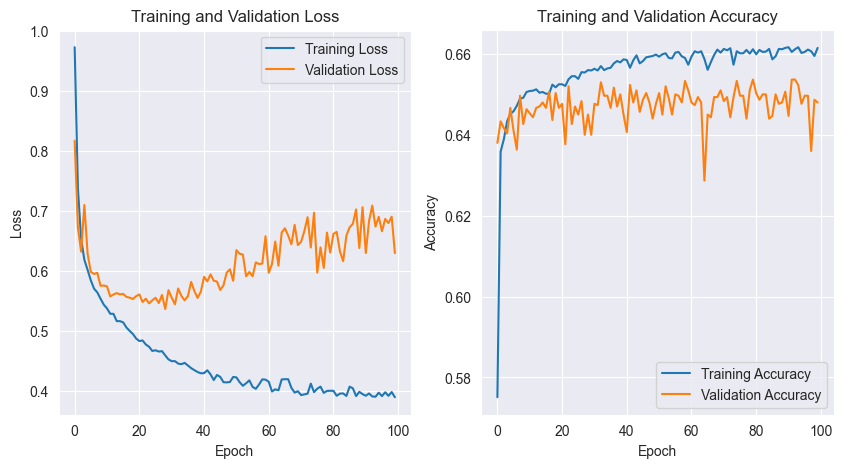

In [13]:
import matplotlib.pyplot as plt

#Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(val_accuracy_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [15]:
outputs = model.predict(X_test)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [16]:
y_pred = np.argmax(outputs, axis=1)
y_pred

array([2, 2, 2, ..., 0, 0, 2], dtype=int64)

In [17]:
INDEX = 6

out = model.predict([X_test[:2500][INDEX]])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])

Predicted class: calculator
True class: calculator


C:\Users\yeray142\AppData\Local\Temp\ipykernel_12544\3657370401.py:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  x = torch.tensor(x, dtype=torch.float32)
C:\Users\yeray142\AppData\Local\Temp\ipykernel_12544\3657370401.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc4(x))
